# Run after Step 1 is finished. This is the meat of the analysis process!

The final outputs of this code are the characteristic decay times (taus), the fit parameters that resulted in the taus, and a basic picture of what the data looks like for a particular video or sample.

You need to be careful with the way you handle the data. There is a lot of data to work with, save, and organize. I would recommend in the beginning going video by video. Once you feel more confident then you could go sample by sample.

This is a very interactive code, you will probably have to run steps multiple times before you get fits that work well. Try to keep track of where you are in the code and what you have run so far, it will help you save time in the long run.

Step 1. Initialize the necessary python modules. 

In [2]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
sys.path.append('E:\\Differential-Dynamic-Microscopy---Python')
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
import pickle #for saving data
from scipy.special import gamma

C:\Users\devyn\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

Step 2. Define the framerate, the pixel size and the dimension of the ROI you are going to analyze.
** you will also be initializing the newt function, don't worry about it--but we may use it later on in the plotting of data

In [4]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 18.0
px = 0.194
imDimension = 256
q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*(px))) 

Step 3. This step is only to be executed at the beginning of the analysis process or at the start of a new video after you have saved the data from the previous. 
It is very important that you do not run it in the middle of all of your analysis, or each time you run the code because you will lose ALL of you work to that point. 

This step is to initialize a dictionary that will store all of the relevant information for you.

Comment it out after you have initialized it!

In [354]:
allResults = {} #comment me out after I have been run--or you will be very sorry

Step 4. Loading in the FFT file that you want to analyze. Jupyter notebook doesn't really like when you use variable strings so just enter in the numbers manually into the file you want to analyze.

In [362]:
ROI = "768"
video = "7"
Topology = "Circular"
Condition = "None"
data_dir = "W:\\Devynn_2018-2019\\Data\\Paper2_None&Both\\"+Condition+"\\"+Topology+"\\ffts\\"
data_file = "051319_""DNA_None_18fps_55exp_"+video+"_MMStack_Pos0.ome_"+ROI+"_256x256_FFTDIFFS_dts_ravs.p"

dat = pickle.load(open(data_dir+data_file,'rb'))
ravs = dat['ravs'] 
dts  = dat['dts']
ffts = dat['ffts']
times = dts/framerate

Step 5. (Now we will actually start to look at the data! Woohoo!) We are going to begin by finding the background for the data. It's an arbitraty value, but is important in the analysis because the fitting function is pretty sensitive to initial parameters.

We will start by picking a q index that is large. We do this because the data will be mostly a straight line. You will hover your mouse over the middle of the data

![Bg_image](DDM_backgroundEx.PNG) 

So, once you find the value (the poorly drawn black line is an example of where to look) you will enter it back into the variable named backg, and then you will run that section of the code again

Sometimes the background fit looks like it is trying to fit the crazy noise of the data, but the value you chose for the background might still be good.

Like this for example:
![Bg_image_weird](crazyBG_but_goodvalue.PNG)


<IPython.core.display.Javascript object>


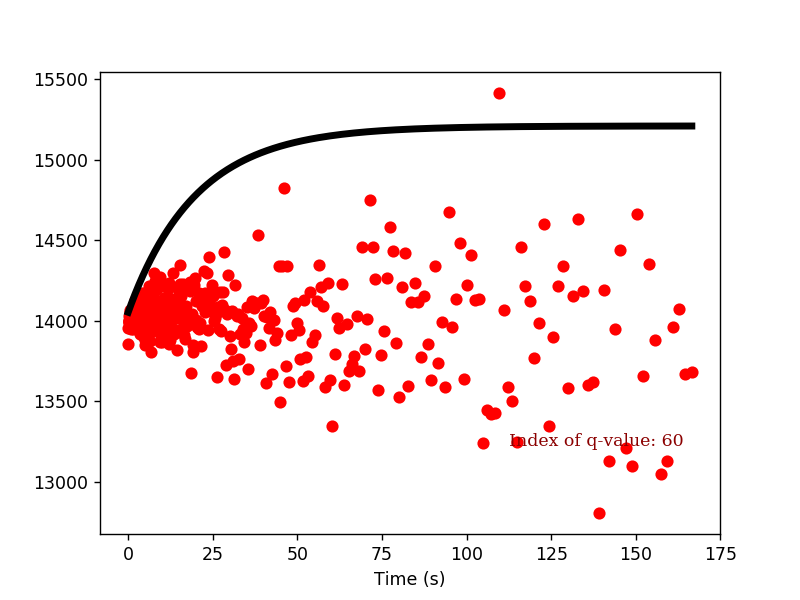

In [364]:
%matplotlib notebook
q_index = 60
backg = 14050 #change me! 

pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index],bg=backg, double=False, fps=framerate)
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

Step 6. Once the background value is set at something that makes sense then run the two_rounds_fitting function which fits the data (the radial averages) to a stretched exponential. We chose a stretched exponential because it fit the data the best. 

There are a few things to keep in mind here.

1. There are really only two initial parameters that you will have to mess with. That is the background and the stretching exponent. Which correspond to pars(2) and pars(3), respectively. (seriously, so important!)

![important](DDM_veryImportant_pars.PNG)

2. Initial parameters are important. I usually allow the stretching exponent to vary within a range that makes sense, and I like to fix the background to the value I found in Step 5. 
3. Sometimes the data might fit a double exponential better and if this is the case you will need to change double=False to double=True.

This step will show you 4 different q values and the fits for each of them. Change the parameters (mostly the stretching exponent and the background) until the fits are good enough. 

Here is an example of some good fits:

![Good_fits](DDM_goodfits.PNG)


Step 6 cont. Run this next section to see the fits plotted.


<IPython.core.display.Javascript object>


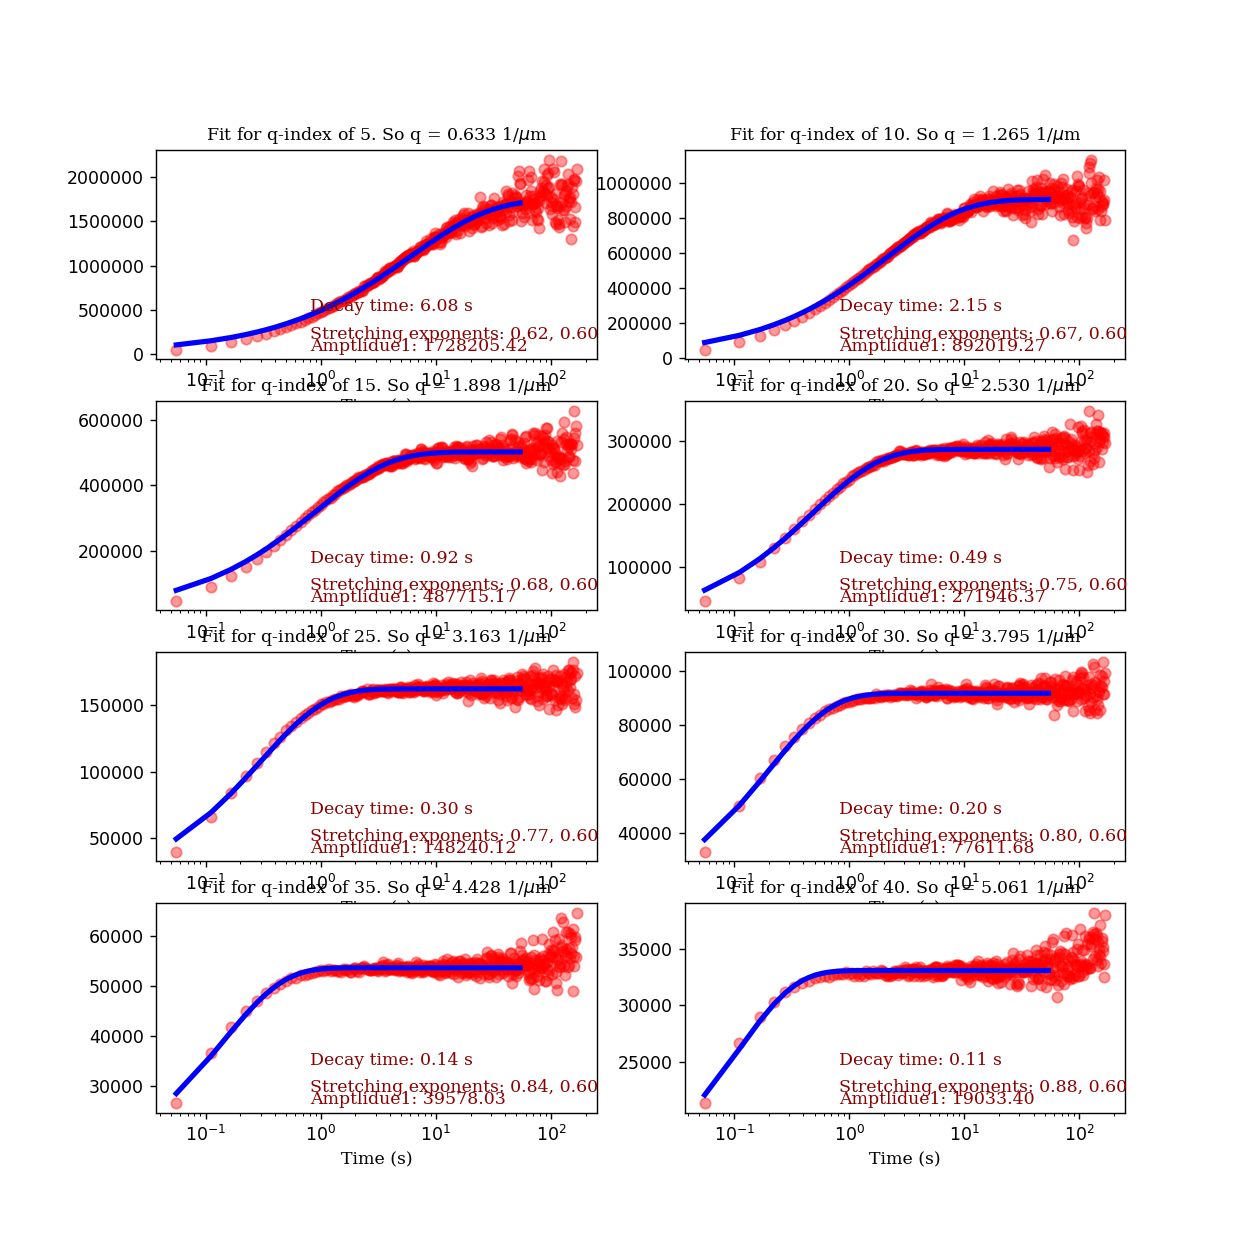

bg: 14050.0
bg: 14050.0
bg: 14050.0
bg: 14050.0
bg: 14050.0
bg: 14050.0
bg: 14050.0
bg: 14050.0


In [365]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''

    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=framerate)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp), (... same for second exp..))
    
    minp[3]=0.5
    maxp[3]=1.0 
    pars[3]=.7
    
    maxp[2]=20000
    minp[2]=100
    pars[2]=backg# change this to the amplitude of the q fit show in the plot above
    

    maxp[1] = 1000
    minp[1] = 0.001
     
    maxp[5] = 100
    
    fix[3]= False #Fix alpha
    fix[2]= True #Fix bg
    
   
    fix[6]= False #6 is the stretching exponent for 2nd exponential
    pars[6] = 0.6
    minp[6] = 0.5 #min alpha2\n",
    maxp[6] = 0.75   #max alpha2\n",
    
    pars[5] = 0.1*pars[1] #5 is the time const for 2nd exponential
    minp[5] = 0.01
    '''
    #Leave this commented out for single exponential fits
    totamp = pars[0]+pars[4] ##0 and 4 are the amplitudes
    pars[4] = 0.4*totamp
    pars[0] = 0.4*totamp
    '''

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

%matplotlib notebook
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)

q_index = 10  # 10 usually works because it tends to fit well for all types of dynamics
end_time = 300  # change this if the data plateaus early, it is where the fitting stops
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20,25,30,35,40]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:end_time,q_index], times[:end_time])
    #print len(theoryB)
    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times[:len(theoryB)], theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.12,'Stretching exponents: %.2f, %.2f' % (fitparamsB[3], fitparamsB[6]), 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.06,'Amptlidue1: %.2f' % (fitparamsB[0]),
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    print("bg:", fitparamsB[2])

# So, you have fixed the background AND changed the stretching exponent range, but your fits still seem kind of bad! You can continue onto the next steps to check out some of the other paramters. Your issue might be there!

Step 7. After you have found the initial parameters that result in good lookin' fits you will continue on and have the function run for all spatial frequencies.

In [366]:
fitparams = np.zeros((ravs.shape[1],7))
theory = np.zeros((ravs.shape[1],len(times[:end_time])))
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
amp2 = np.zeros_like(tau) #amplitude
tau2 = np.zeros_like(tau) #background
alph2 = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
for i in range(1,len(tau)):
    fitparams[i], theory[i], chi2[i] = two_rounds_fitting(ravs[:end_time,i], times[:end_time])
    amp[i] = fitparams[i][0]
    bg[i] = fitparams[i][2]
    tau[i] = fitparams[i][1]
    alph[i] = fitparams[i][3]
    amp2[i] = fitparams[i][4]
    tau2[i] = fitparams[i][5]
    alph2[i] = fitparams[i][6]

Checking the other parameters. This isn't necessarily a step, but is important in understanding the data and maybe why your fits are bad or good.

We will first plot the amplitude vs q values and the background vs q values. The amplitude is an arbitrary number, but it can affect the fitting, specifically if the background is too high and the amplitude is either equal to the background or below the background line.

<IPython.core.display.Javascript object>


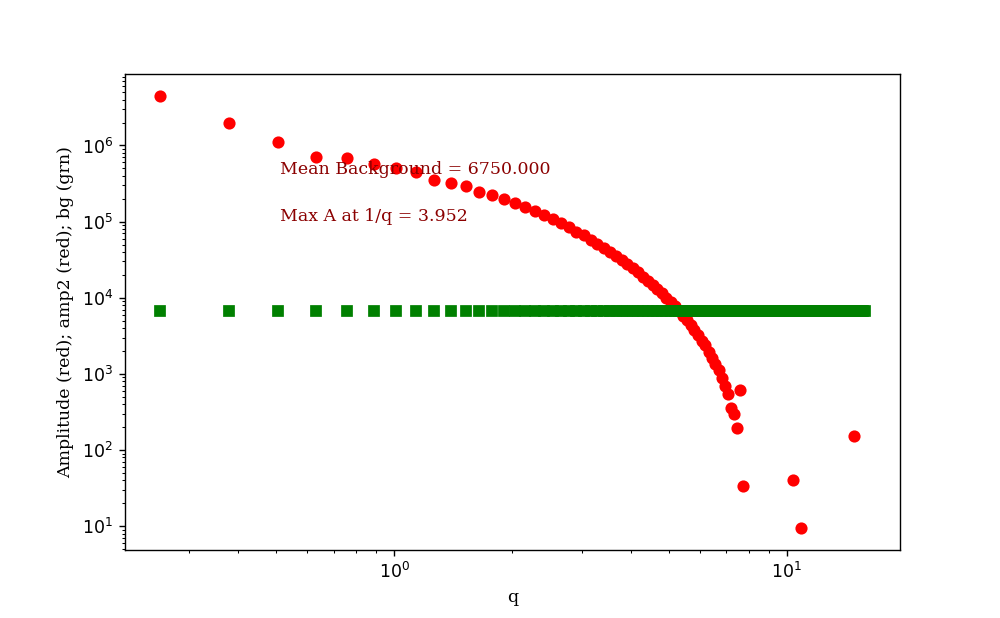

In [53]:
#Plot the amplitude versus the wave vector

fig2 = plt.figure(figsize=(8,8/1.618)); ax = fig2.gca(); 
ax.loglog(q[2:-2], amp[2:-1], 'ro')
ax.loglog(q[2:-2], amp2[2:-1], 'bd')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[2:-2][w]
ax.loglog(q[2:-2], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); amp2 (red); bg (grn)", fontdict=font_plt_ax)

ax.text(0.2,0.7,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);
ax.text(0.2,0.8,'Mean Background = %.3f' % (bg[4:14].mean()), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);

Next we can check the stretching exponent. We have already set a range for the exponents, but this range could be bad. You can tell that it is bad if there are a bunch of points at the max or min of the range and then very few in the middle. Go change the range if this is the case!

<IPython.core.display.Javascript object>


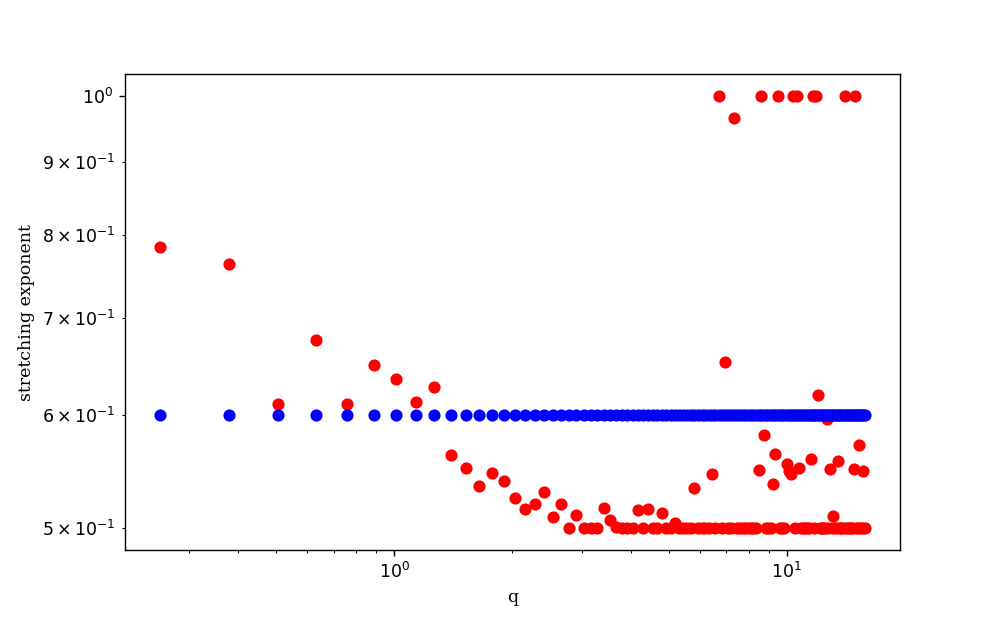

Text(0,0.5,'stretching exponent')

In [45]:
#Plot the str exponent versus the wave vector
fig2 = plt.figure(figsize=(8,8/1.618)); ax = fig2.gca(); 
ax.loglog(q[2:-2], alph[2:-1], 'ro')
ax.loglog(q[2:-2], alph2[2:-1], 'bo')
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("stretching exponent", fontdict=font_plt_ax)

After everything above looks good or if you want to make sure you are actually getting something, continue onto this next step.

Step 8. Plot the decay times! You can also get a rough estimate of the transport coefficient and the type of dynamics in the same by changing the variable that says diffusion_coeff. 

<IPython.core.display.Javascript object>


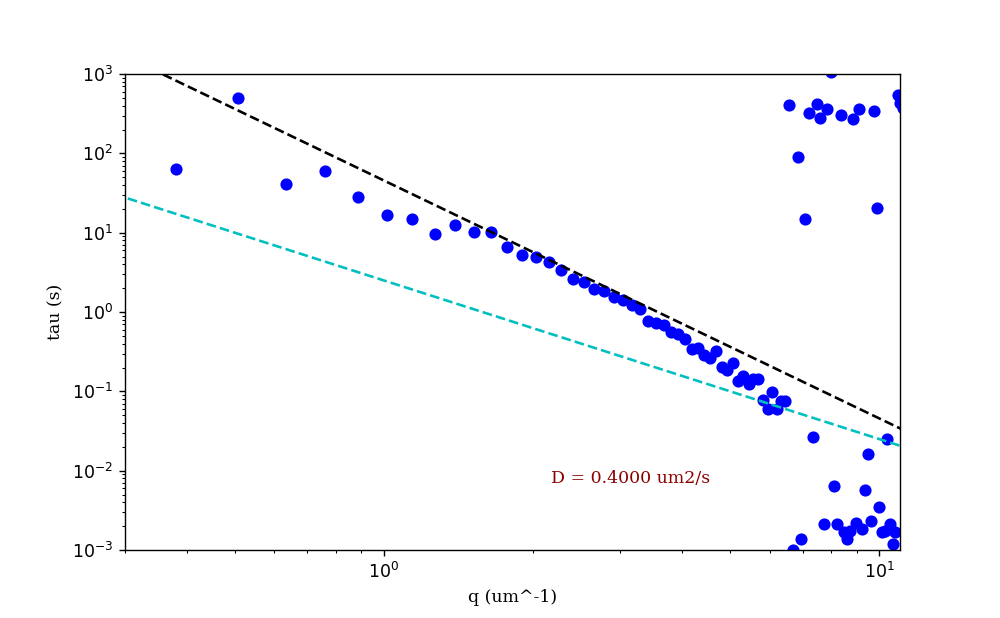

Text(0,0.5,'tau (s)')

In [46]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
#ax.loglog(q[3:-1], tau[2:-1], 'ro')
qs = q[2:-2]

q0=q[2:-31]
tau0 = ddm.newt(tau[2:-30],alph[2:-30])
#ax.loglog(qs, tau[2:-1], 'ro')
ax.loglog(q[2:-31], ddm.newt(tau[2:-30],alph[2:-30]),'bo') # this is for the first exponential
#ax.loglog(q[2:-31],tau[2:-30],'ro')
#ax.loglog(q[3:-30], ddm.newt(tau2[2:-30],alph2[2:-30]),'ro') # this is for the second
#ax.loglog(q[3:-30], tau2[2:-30],'go')

ax.set_xlim(0.3,11)
ax.set_ylim(0.001,1000)

## q^-2, does it look diffusive ?
diffusion_coeff = .4 # you can change this to get a rough estimate of the diffusion coef
power = 2.0 
ax.plot(q[2:-2], (1./diffusion_coeff) * 1./(q[2:-2]**power), '--c', label="Diffusive")


## does it fit some other power?
adiffusion_coeff = .022
power2 = 3
ax.plot(q[2:-2], (1./adiffusion_coeff) * 1./(q[2:-2]**power2), '--k')

#adiffusion_coeff = 0.018
#power2 = 1
#ax.plot(q[2:-2], (1./adiffusion_coeff) * 1./(q[2:-2]**power2), '--k')


ax.text(0.55,0.15,'D = %.4f um2/s' % diffusion_coeff,
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
#plt.savefig(data_dir+'Plot' + ROI[c] +'.png')
#################################################################################################
#################################################################################################


Step 9. If everything looks good. There is a straight line for the decay time verses spatial frequencies then you should save the data into the dictionary you initialized in Step 3. This will be a nice way for you to save everything that is important, uyou will be using it again later on!  

In [367]:

allResults['fitparams_'+video+'_'+ROI] = fitparams
allResults['theory_'+video+'_'+ROI] = theory
allResults['chi2_'+video+'_'+ROI] = chi2
allResults['ravs_'+video+'_'+ROI] = ravs
allResults['dts'] = dts

In [ ]:
allResults['']

In [368]:
allResults.keys()

['chi2_7_768',
 'fitparams_7_768',
 'fitparams_7_512',
 'chi2_7_512',
 'theory_7_768',
 'theory_7_512',
 'ravs_7_768',
 'ravs_7_512',
 'dts']

Step 10. Repeat steps 4-9 again until you have analyzed every ROI in the video or have finished all of the videos (let's just stick with ROIs in the video for the time being).

Step 11. Once you have saved all of the information into the dictionary above you will want to export and save the dictionary as a '.p' file. Make sure to save two of the same files, just in case you accidently overwrite one later on--cover all of your bases.

In [369]:
pickle.dump(allResults, open("W:\\Devynn_2018-2019\\Data\\Paper2_None&Both\\Entangled_Networks\\Circular\\allResults\\allResults_051319_"+video+"_512768.p",'wb'))

In [ ]:
pickle.dump(allResults, open('Z:\\Wherever_you_are_planning_on_putting_these_files\\allResults_the_video_number_and_other_info_date_1.p','wb'))
pickle.dump(allResults, open('Z:\\Wherever_you_are_planning_on_putting_these_files\\allResults_the_video_number_and_other_info_date_2.p','wb'))